In [307]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md


import warnings
warnings.filterwarnings(action='ignore') 



sns.set(style='whitegrid')
plt.rcParams['font.family'] = 'Gulim'

In [308]:

# 분석에 쉽게 column명을 한글로 바꾸줌
def column_to_kor(database):
    new_columns = [
            '창고코드',
           '고객 주문번호',
            'CJ대한통운 주문번호(예약번호)',
           '주문유형',
           '주문 날짜',
            '주문 시간',
            '고객사코드',
            '주문금액',
            '품목순번',
            '품목코드',
            '브랜드',
            '품목수량',
            '품목금액',
            '수신여부',
            '주문생성시간',
            '택배구분',
            '상품주문번호',
            '중개업체 주문번호',
            '접수여부',
            '배달예정점소코드',
            '배달예정사원분류코드',
            '배달터미널코드',
            '배달터미널 소분류코드',
            '입력자ID',
            '입력일자(인터페이스 시간)',
            '입력시간(인터페이스시간)',
            '권역구분',
            '배송처별 주문분할여부',
            '송화인 주소1',
            '송화인 주소2',
            '수화인 주소1',
            '수화인 주소2',
]
    
    for i in range(len(database)):
        database[i].columns = new_columns
    return database


# 3,4,5,6월 데이터를 불러오는 과정에 한 번에 합쳐줌
def readCsv(path):
    chunksize = 10 ** 5
    database = []

    for p in path:
        tmp = pd.read_csv(p, chunksize=chunksize, low_memory=False)
        df = pd.concat(tmp, ignore_index = True)
        database.append(df)
     # colname 한글화
    database = column_to_kor(database)
    
    # '월 column 추가'
    for i in range(len(database)):
        database[i]['월'] = i + 3

    new_db = pd.concat([db for db in database])
    return new_db



In [309]:
path = ['./database/FC3.csv',
       './database/FC4.csv',
       './database/FC5.csv',
       './database/FC6.csv',]

df = readCsv(path)

# 데이터 탐색


## 받은 데이터에 대한 가설 : e-fullfillment 서비스 대상 기업의 물류 처리 자료라고 가정

- e-풀필먼트 : 대한통운이 2020년부터 추진하고 있는 사업으로 네이버와 협력해 e-commerce시장의 질적 성장을 견인
- 상품의 보관, 주문에 따른 출고와 배송, 재고관리까지 한 번에 관리해주며 중간과정 생략으로 배송속도 향상 등 소비자와 고객사에게 Win-Win인 서비스
- 이용업체의 70% 이상이 판매량 25% 증가를 경험하는 등 고객사 매출 증진에 큰 역할을 함

## 고객사 코드 분석
- 데이터는 한 csv file마다 적게는 30만 개, 많게는 60만 개인데, 고객사 수는 29개로 매우 적음
- 즉, 일반적인 택배 처리가 아닌, 특정 고객사를 대상으로 하는 **특별한** 물류 처리 프로세스임을 유추
- 이 점에 주목해 관련 기사 및 자료를 조사

In [310]:
# - 데이터에 존재하는 데이터
march = set(df[df['월'] == 3]['고객사코드'].unique())
april = set(df[df['월'] == 4]['고객사코드'].unique())
may = set(df[df['월'] == 5]['고객사코드'].unique())
june = set(df[df['월'] == 6]['고객사코드'].unique())

all_customers = len(march | april | may | june)
print('고객사 수 : ', all_customers)
print('총 데이터 길이 : ', len(df))

고객사 수 :  29
총 데이터 길이 :  1786374


## 곤지암, 군포 물류센터 분석

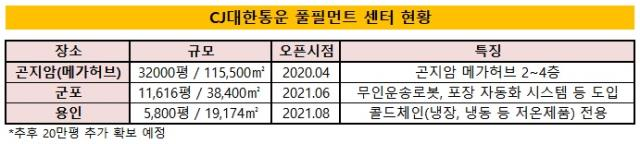

- 창고코드에는 곤지암(KX007)과 군포(GP001) 두 코드만 존재
- 3, 4월달에는 곤지암에서만 데이터가 발생하고, 5, 6월부터 군포에서도 데이터가 발생
- (기사를 참고해보면 군포 풀필먼트 센터 오픈시점은 6월 달)
- 군포 센터는 6월달부터 오픈한다 했으나 5월에도 GP001에서 데이터가 발생해 확인한 결과, 5월 말(5/27~)부터 데이터가 발생하고 처리 물량도 약 **1%** 안팎인 점을 들어, 정식 개장에 앞서 **시범가동** 중이라고 추측할 수 있다.
- 참고로 정식으로 언론보도 된 시점이 6월 20일 즈음이지만, 다른 기사를 검색해 본 결과, 6월 9일 기준 이미 문을 열었다고 나옴

사진 출처
https://www.thebell.co.kr/free/content/ArticleView.asp?key=202107261257536040104947&lcode=00

관련기사
https://www.edaily.co.kr/news/read?newsId=01180806629083688&mediaCodeNo=257&OutLnkChk=Y

6월 9일 기사
https://www.hankyung.com/economy/article/2021060921821

In [311]:
for i in range(4):
    print(f'{i+3}월 창고코드 : \n', df[df['월'] == i+3]['창고코드'].value_counts(), end='\n\n')
    

3월 창고코드 : 
 KX007    309352
Name: 창고코드, dtype: int64

4월 창고코드 : 
 KX007    349588
Name: 창고코드, dtype: int64

5월 창고코드 : 
 KX007    445435
GP001      5087
Name: 창고코드, dtype: int64

6월 창고코드 : 
 KX007    501635
GP001    175277
Name: 창고코드, dtype: int64



## 고객사 상세 분석
- 현재 네이버 브랜드스토어와 물류협약을 맺고 있으며, 특정 고객사들의 언론기사 등에서 명단을 알아내고 주어진 데이터에서 이를 역추적하는 방식을 사용
- 실제 기사에 적힌 고객사와 INS_ID(입력자ID) column에서 특정 고객사임을 유추할 수 있는 단어가 있음을 알아냄
- 올해 1월 기준 고객사 : LG생활건강, 라이온코리아, 애경산업, 네슬레코리아, 생활공작소, 대상라이브사이언스, 뉴트리원

- 출처 : https://www.sedaily.com/NewsView/22HGYHM6XT



In [312]:
# 예를 들어 90001541같은 경우, '입력자ID(INS_ID)의 unique 값을 보면 nestle90라는 값이 나오는데 이를 통해 해당 코드가 네슬레코리아라고 유추할 수 있었다 
df_nums = df['고객사코드'].unique().tolist()
for num in df_nums:
    INS_list = df[df['고객사코드'] == num]['입력자ID'].unique()
    print(f"{num}고객사의 INS_ID 목록 : {INS_list}")

90001302고객사의 INS_ID 목록 : ['iNEXBatch' 'sibizi22' 'sibizi28' 'sibizi56' 'BATCH' 'sibizi47'
 'sibizi49' 'sibizi53' 'sibizi27' 'AK04']
90001441고객사의 INS_ID 목록 : ['iNEXBatch' 'LION02' 'LION03' 'LION08' 'LION05' 'BATCH']
90001542고객사의 INS_ID 목록 : ['iNEXBatch' 'nutrione06' 'nutrione01' 'nutrione03' 'nutrione11' 'BATCH'
 'nutrione10']
90001341고객사의 INS_ID 목록 : ['iNEXBatch' 'life03' 'BATCH' 'life01']
90001541고객사의 INS_ID 목록 : ['iNEXBatch' 'NESTLE11' 'NESTLE09' 'NESTLE04' 'BATCH']
90001443고객사의 INS_ID 목록 : ['iNEXBatch' 'AK04' 'BATCH' 'AK05']
90001381고객사의 INS_ID 목록 : ['iNEXBatch' 'vanada01']
90001521고객사의 INS_ID 목록 : ['iNEXBatch' 'daesang01']
90001502고객사의 INS_ID 목록 : ['BATCH' 'yangji03' 'yangji02' '13406634_WEB']
90001562고객사의 INS_ID 목록 : ['MIMI01']
90001582고객사의 INS_ID 목록 : ['iNEXBatch' 'CHANSOL01' 'BATCH' 'CHANSOL02']
90001602고객사의 INS_ID 목록 : ['iNEXBatch' 'GNM01' 'GNM02' '13406634_WEB' 'BATCH' 'GNM04']
90001683고객사의 INS_ID 목록 : ['daechungim01' 'iNEXBatch' 'daechungim02']
90001622고객사의 INS_ID 목록 : ['YUHA

### - 위에 언급한 내용만으로 고객사를 특정하기 애매한 경우는 다음과 같이 다각도로 분석했다.
- 아래는 lg생활건강이 90001302임을 알아낸 과정을 보기 쉽게 재현했으며, 다른 기업도 이와 같은 흐름으로 분석함


## 근거 1: 송화인 주소와 고객사의 물류창고 위치 대조
- 가정 : 고객사의 물류창고(송화인 주소)에서 cj 풀필먼트 센터로 입고될 것
 1. 세종 https://www.saramin.co.kr/zf_user/jobs/view?rec_idx=39666832
 2. 청주 https://www.saramin.co.kr/zf_user/jobs/view?rec_idx=40923625


In [313]:
# 송화인 주소를 바탕으로 검색
unknown_df = df[df['고객사코드'] == 90001302]
unknown_df['송화인 주소'] = unknown_df['송화인 주소1'].fillna('') + unknown_df['송화인 주소2'].fillna('')

#다음과 같이 세종시, 청주시가 나온다는 것을 확인
print(unknown_df['송화인 주소'].unique())


['세종특별자치시' '경기도광주시' '경기도' '경기광주시' '충청북도청주시']


## 근거 2: 물동량이 뛰는 날은 이벤트 등의 외적 요인이 있을 거라 가정해 실제 이벤트 날짜와 물동량 그래프를 통해 관계 확인

90001302(LG생활건강)의 경우, 시간 - 물동량 그래프에서 물동량이 높은 날(3/23, 4/20, 5/17, 6/13 등)에는 실제로 브랜드데이나 쇼핑라이브 등의 이벤트가 존재했음을 알 수 있다.
- 3/23 : 브랜드 데이와 쇼핑 라이브를 동시 진행
- 4/20 : 봄맞이 브랜드 데이, 쇼핑 라이브 동시 진행
- 5/17 : '가정의 달' 브랜드 데이, 쇼핑 라이브 동시 진행
- 6/13 : 레드 위크, 쇼핑 라이브 동시 진행
- 6/8 : 레드 위크, 쇼핑 라이브 동시 진행
- 출처 : https://brand.naver.com/lgcaremall/shoppingstory/list?cp=2

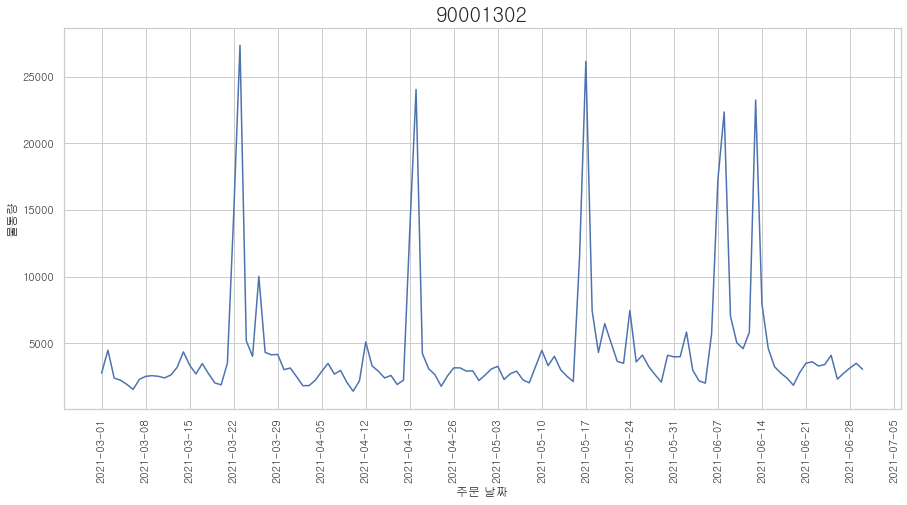

In [314]:
# 90001302를 다운샘플링 하여 일일 물동량으로 변환 후 물동량 분석
qty_df = unknown_df[unknown_df['주문유형'] == 7].groupby(['주문 날짜'])['품목수량'].sum().reset_index()

qty_df['주문 날짜'] = pd.to_datetime(qty_df['주문 날짜'], format="%Y%m%d")


plt.figure(figsize=(15, 7))
ax = plt.subplot(1,1,1)
sns.lineplot(data = qty_df, x='주문 날짜', y='품목수량')

ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 0))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
ax.xaxis.set_minor_locator(md.DayLocator(interval = 1))
plt.title(f'{90001302}', fontdict={'fontsize': 20})
plt.ylabel('물동량')
plt.show()

## 위 주석에서 설명한 이벤트와 물동량 - 주문 날짜 그래프의 peak가 일치함

In [315]:
qty_df.sort_values(by='품목수량', ascending=False)

,주문 날짜,품목수량
22,2021-03-23,27349
77,2021-05-17,26144
50,2021-04-20,24034
104,2021-06-13,23245
99,2021-06-08,22351
...,...,...
33,2021-04-03,1835
32,2021-04-02,1824
54,2021-04-24,1780
5,2021-03-06,1545


## 기업별 데이터 물동량 변화 예시
- 데이터는 대부분 아래과 같이 특정 날에 폭증하는 양상을 보임

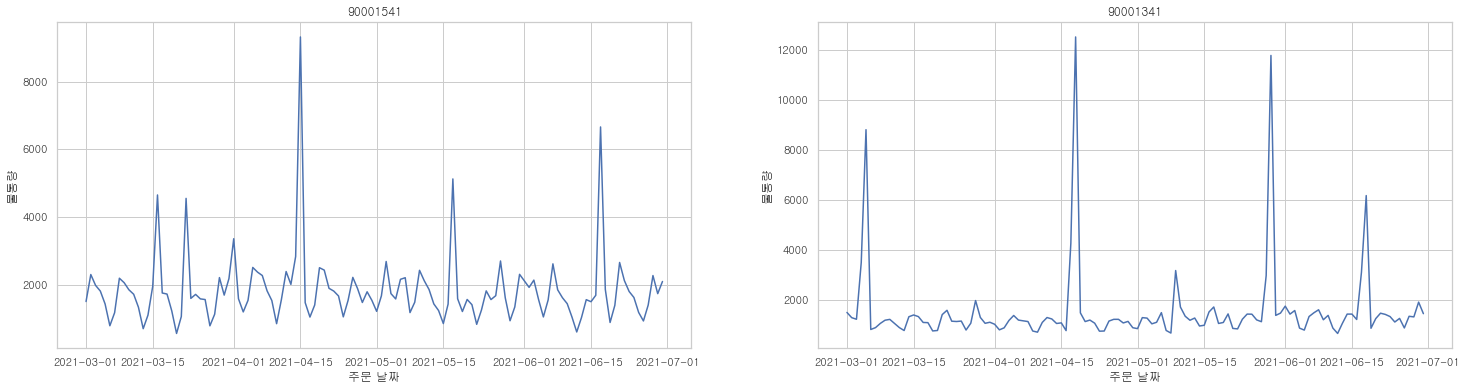

In [316]:
tmp_df1 =  df[df['고객사코드'] == 90001541]
tmp_df1 = tmp_df1[tmp_df1['주문유형'] == 7].groupby(['고객사코드', '주문 날짜'])['품목수량'].sum().reset_index()
tmp_df2 =  df[df['고객사코드'] == 90001341]
tmp_df2 = tmp_df2[tmp_df2['주문유형'] == 7].groupby(['고객사코드', '주문 날짜'])['품목수량'].sum().reset_index()


tmp_list = [tmp_df1, tmp_df2]
plt.figure(figsize=(25, 6))
for i, tmp_db in enumerate(tmp_list):
    ax1 = plt.subplot(1, 2, i+1)
    tmp_db['주문 날짜'] = pd.to_datetime(tmp_db['주문 날짜'], format="%Y%m%d")
    sns.lineplot(data = tmp_db, x='주문 날짜', y='품목수량', ax=ax1, )
    num = tmp_db['고객사코드'][0]
    plt.title(f'{num}')
    plt.ylabel('물동량')

# 데이터 전처리

 - B2C출고가 7인 데이터 및 주문금액이 NaN값이 아닌 데이터만 선택
 - 주문금액이 아예 없는 경우는 품목 금액도 빠져있는 등 결측치가 많아 제외
 - 총 28011개의 데이터이며 전체 데이터의 약 1.56%로 차지하는 비중도 무시할 수 있을 정도

In [317]:
# 실제 고객사에게 가는 B2C 출고만 계산
# 주문금액이 결측치인 경우 품목금액같은 column들도 결측치인 경우가 많아 비정상적인 데이터라 판단해 제외
drop_df = df[(df['주문금액'].isna() == True)]
print('주문금액이 결측치인 데이터의 비율 : {:.2f}%'.format(len(drop_df) / len(df) * 100))

print('B2C출고 및 주문금액이 결측치가 아닌 데이터를 새로 분리')
new_df = df[(df['주문유형'] == 7) & (df['주문금액'].isna() == False)]
new_df.head()

주문금액이 결측치인 데이터의 비율 : 1.57%
B2C출고 및 주문금액이 결측치가 아닌 데이터를 새로 분리


,창고코드,고객 주문번호,CJ대한통운 주문번호(예약번호),주문유형,주문 날짜,주문 시간,고객사코드,주문금액,품목순번,품목코드,...,입력자ID,입력일자(인터페이스 시간),입력시간(인터페이스시간),권역구분,배송처별 주문분할여부,송화인 주소1,송화인 주소2,수화인 주소1,수화인 주소2,월
0,KX007,2021030365922551,KX007210303370934,7,20210303,35510,90001302,22400.0,2,134265392,...,iNEXBatch,20210303,131425,3.0,N,세종특별자치시,NaN,서울특별시,서대문구,3
1,KX007,2021030365922951,KX007210303371080,7,20210303,35521,90001441,20900.0,1,4610261043_2,...,iNEXBatch,20210303,131425,50.0,N,경기도,광주시,경상남도,김해시,3
2,KX007,2021030365924361,KX007210303371081,7,20210303,35513,90001441,37900.0,1,4936599538_1,...,iNEXBatch,20210303,131425,53.0,N,경기도,광주시,경상남도,거제시,3
3,KX007,2021030365928921,KX007210303371205,7,20210303,35608,90001542,69800.0,1,3858391637_1,...,iNEXBatch,20210303,131425,6.0,N,경기도,광주시,서울특별시,서초구,3
4,KX007,2021030365930451,KX007210303370967,7,20210303,35551,90001341,73700.0,1,4631307460,...,iNEXBatch,20210303,131425,10.0,N,경기도,광주시,경기도,김포시,3


In [318]:
# 다운 샘플링(실제 초 단위까지 나오는 주문시간대를 일별 몰동량으로 분석하기 위함)

new_df['주문 날짜'] = pd.to_datetime(new_df['주문 날짜'],  format='%Y%m%d')
new_df = new_df.groupby(['고객사코드', '주문 날짜'])['품목수량'].sum().reset_index()
new_df.head()

,고객사코드,주문 날짜,품목수량
0,90001302,2021-03-01,2772
1,90001302,2021-03-02,4334
2,90001302,2021-03-03,2326
3,90001302,2021-03-04,2189
4,90001302,2021-03-05,1903


## 25개 기업 중, 상위 10개 고객사가 차지하는 비율이 85%가 넘는다

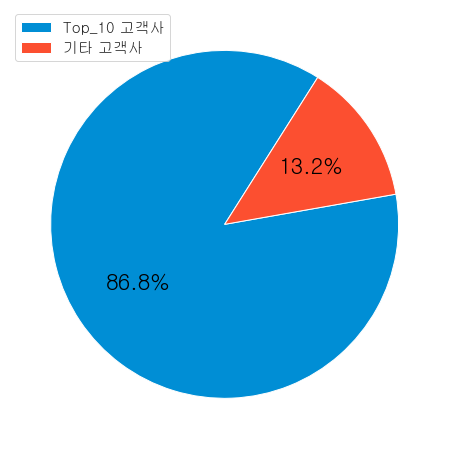

In [319]:
tmp = new_df.groupby(['고객사코드'])['품목수량'].sum().sort_values(ascending=False)
ratio = [tmp[:10].sum(), tmp[10:].sum()]
labels = ['Top_10 고객사', '기타 고객사']


fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 배경색을 하얀색으로 설정
ax = fig.add_subplot() ## 프레임 생성

# pie chart
pie = ax.pie(ratio,
       startangle=10,
       counterclock=False,
       autopct=lambda p : '{:.1f}%'.format(p),
       colors = ['#008ed5', '#fc4f30'],
       textprops={'fontsize': 22, 'color' : 'black'},
        
       )
 
plt.legend(pie[0], labels, fontsize=15, loc='upper left') ## 범례 표시
plt.show()

In [320]:
df['고객사코드'].unique()

array([90001302, 90001441, 90001542, 90001341, 90001541, 90001443,
       90001381, 90001521, 90001502, 90001562, 90001582, 90001602,
       90001683, 90001622, 90001662, 90001682, 90001705, 90001664,
       90001703, 90001702, 90001704, 90001768, 90001776, 90001765,
       90001774, 90001762, 90001772, 90001842, 90001802], dtype=int64)

## 또한 다음 그래프와 같이 주어진 데이터의 구간이 짧고, 물동량도 거의 없어 분석이 어려울거라 예상되는 데이터도 존재함

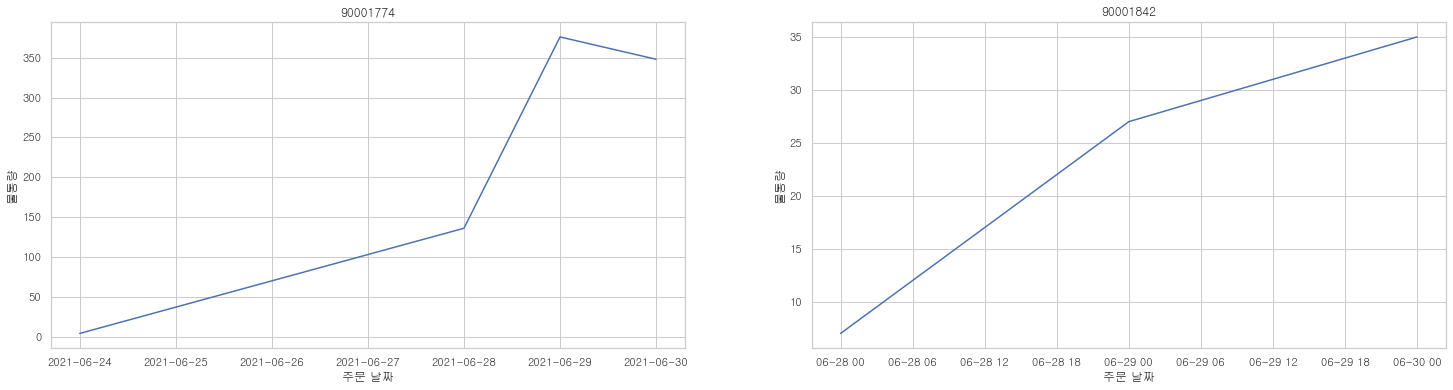

In [321]:
tmp_df1 =  df[df['고객사코드'] == 90001774]
tmp_df1 = tmp_df1[tmp_df1['주문유형'] == 7].groupby(['고객사코드', '주문 날짜'])['품목수량'].sum().reset_index()
tmp_df2 =  df[df['고객사코드'] == 90001842]
tmp_df2 = tmp_df2[tmp_df2['주문유형'] == 7].groupby(['고객사코드', '주문 날짜'])['품목수량'].sum().reset_index()


tmp_list = [tmp_df1, tmp_df2]
plt.figure(figsize=(25, 6))
for i, tmp_db in enumerate(tmp_list):
    ax1 = plt.subplot(1, 2, i+1)
    tmp_db['주문 날짜'] = pd.to_datetime(tmp_db['주문 날짜'], format="%Y%m%d")
    sns.lineplot(data = tmp_db, x='주문 날짜', y='품목수량', ax=ax1, )
    num = tmp_db['고객사코드'][0]
    plt.ylabel('물동량')
    plt.title(f'{num}')

## 분석에 사용할 상위 10개 기업의 데이터를 추출하고 주문 날짜를 datetime 형식으로 변환하는 등 실제 사용할 DataFrame을 구성

In [322]:
top_10_num_list = new_df.groupby(['고객사코드'])['품목수량'].sum().sort_values(ascending=False).index[:10].tolist()
top_10_df = new_df[new_df['고객사코드'].isin(top_10_num_list)].reset_index(drop=True)
top_10_df['주문 날짜'] = pd.to_datetime(top_10_df['주문 날짜'], format="%Y%m%d")
top_10_df.head()

,고객사코드,주문 날짜,품목수량
0,90001302,2021-03-01,2772
1,90001302,2021-03-02,4334
2,90001302,2021-03-03,2326
3,90001302,2021-03-04,2189
4,90001302,2021-03-05,1903


## 이상치 및 결측치 처리
- 분석 결과, 90001602와 60001622에서 지나치게 낮은 이상치 및 결측값 발견(결측치는 4월 20일과 5월 11일)
- 두 고객사의 공통점은 결측치 이전 날들은 물동량이 한 자리수인 매우 비정상적인 양상을 보이고 있어서 결측치 처리함
- 지나치게 높은 값은 이벤트에 영향을 받은 부분으로 판단되는 데이터가 대부분이라 이상치 처리를 따로 진행하지 않음

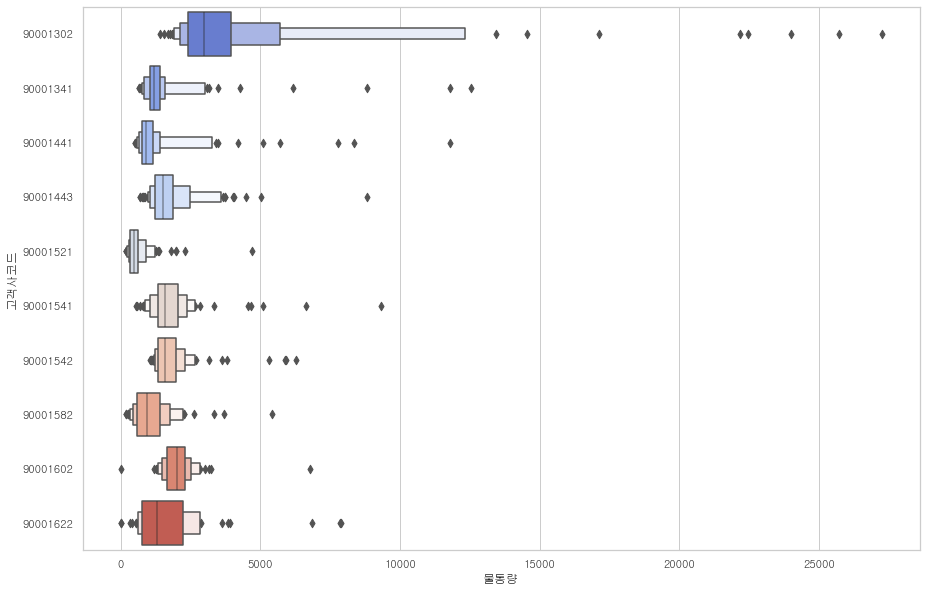

In [323]:
# 이상치 탐색
plt.figure(figsize=(15, 10))
ax = sns.boxenplot(data=top_10_df, x='품목수량', y='고객사코드', palette = 'coolwarm', orient='h')
plt.xlabel('물동량')
plt.show()

In [324]:
top_10_df[(top_10_df['품목수량'] < 10)]

,고객사코드,주문 날짜,품목수량
946,90001602,2021-04-19,1
1018,90001622,2021-05-09,1
1019,90001622,2021-05-10,4


## 10 미만의 값 및 결측값은 중앙값으로 대체
## 결측값을 중앙값으로 대체하는 이유는 현재 가지고 있는 데이터가 outlier이 너무 많아 평균으로 하면 outlier의 영향을 크게 받기 때문

In [325]:
from datetime import datetime

# 결측치를 중앙값으로 대체
tmp_1 = top_10_df[top_10_df['고객사코드'] == 90001602]
day_1 = datetime.strptime("2021-04-20", '%Y-%m-%d')
line = pd.DataFrame({"고객사코드": 90001602, "주문 날짜": day_1, "품목수량" : int(tmp_1['품목수량'].median())}, index=[947])
top_10_df = pd.concat([top_10_df.iloc[:947], line, top_10_df.iloc[947:]]).reset_index(drop=True)

tmp_2 = top_10_df[top_10_df['고객사코드'] == 90001622]
day_2 = datetime.strptime("2021-05-11", '%Y-%m-%d')
line = pd.DataFrame({"고객사코드": 90001622, "주문 날짜": day_2, "품목수량" : int(tmp_2['품목수량'].median())}, index=[1021])
top_10_df = pd.concat([top_10_df.iloc[:1021], line, top_10_df.iloc[1021:]]).reset_index(drop=True)

In [326]:
# 10보다 작은 물동량 또한 중앙값으로 대체

top_10_df.loc[946, '품목수량'] = int(tmp_1['품목수량'].median())
top_10_df.loc[1019, '품목수량'] = int(tmp_2['품목수량'].median())
top_10_df.loc[1020, '품목수량'] = int(tmp_2['품목수량'].median())

In [327]:
# 최종적으로 결측값 유무 확인
print('10 미만 이상치 : ',len(top_10_df[(top_10_df['품목수량'] < 10)]), end='\n\n')
print('--결측치 개수--')
print(top_10_df.isna().sum())

10 미만 이상치 :  0

--결측치 개수--
고객사코드    0
주문 날짜    0
품목수량     0
dtype: int64


## 이벤트 데이터 수집
- 네이버 브랜드스토어 공식몰 및 쇼핑파트너 공식블로그 등을 통해 얻은 정보를 바탕으로 구성
- 이벤트는 하루에 여러 개가 동시 발생할 수 있음
- 그래프를 통해 실제 물동량과 이벤트 발생일을 비교해보니 유의미한 관계가 있다는걸 알아냄
- 회귀분석을 통해 통계적으로 유의미한 이벤트만 선택(기타 대부분 제외)

## 참고 사이트
- 네이버 쇼핑파트너 공식블로그 : https://blog.naver.com/naver_seller/222284666745
- 특정한 각 기업별 네이버 공식몰(Ex. 대상웰라이프) : https://brand.naver.com/dswellife/shoppingstory/list?cp=2

In [328]:
pip list

Package                 VersionNote: you may need to restart the kernel to use updated packages.

----------------------- ---------
absl-py                 0.14.1
argon2-cffi             21.1.0
asgiref                 3.4.1
astunparse              1.6.3
async-generator         1.10
attrs                   21.2.0
backcall                0.2.0
bleach                  4.1.0
Bottleneck              1.3.2
brotlipy                0.7.0
cachetools              4.2.4
certifi                 2021.10.8
cffi                    1.14.6
charset-normalizer      2.0.6
cmdstanpy               0.9.5
colorama                0.4.4
convertdate             2.3.2
cryptography            3.4.8
cycler                  0.10.0
Cython                  0.29.24
debugpy                 1.5.0
decorator               5.1.0
defusedxml              0.7.1
Django                  3.2.8
entrypoints             0.3
ephem                   4.1
et-xmlfile              1.1.0
fbprophet               0.7.1
flatbuffers           

In [329]:
event_df = pd.read_excel('./database/event.xlsx', usecols = ['고객사코드', '주문 날짜', '이벤트'])
event_df['주문 날짜'] = pd.to_datetime(event_df['주문 날짜'])

# 이벤트를 one-hot-encoding해준다
tmp_col = event_df['이벤트'].str.join("").str.get_dummies(",")
event_df = pd.concat([event_df.iloc[:, :-1], tmp_col], axis=1)
event_df

,고객사코드,주문 날짜,기타,브랜드데이,브랜드위크,쇼핑라이브,타임특가
0,90001302,2021-03-12,0,0,0,0,1
1,90001302,2021-03-22,0,0,1,1,0
2,90001302,2021-03-23,0,1,1,1,0
3,90001302,2021-03-24,0,0,1,0,0
4,90001302,2021-03-25,0,0,1,0,0
...,...,...,...,...,...,...,...
158,90001582,2021-06-25,0,0,0,0,1
159,90001582,2021-06-28,0,0,0,1,0
160,90001622,2021-03-11,0,0,0,0,1
161,90001622,2021-03-25,0,0,0,0,1


## 90001302(LG생활건강)을 예시로 들어 물동량과 이벤트 발생건수를 그래프로 나타내 비교

In [330]:
event_df_tmp = event_df.copy()
event_df_tmp['합']= event_df[['기타', '브랜드데이', '브랜드위크', '쇼핑라이브', '타임특가']].sum(axis=1)


for_plot_df = pd.merge(top_10_df, event_df_tmp, how='left', on=['고객사코드', '주문 날짜']).fillna(0)

plt.figure(figsize=(15, 7), constrained_layout=True)
                    
ax1 = plt.subplot(2,1,1)

tmp_df = for_plot_df[for_plot_df['고객사코드'] == top_10_num_list[0]]
tmp_df['주문 날짜'] = tmp_df['주문 날짜'].astype(str)
sns.barplot(data=tmp_df, x='주문 날짜', y='합', palette='Blues')
ax1.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 0))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation = 90)
ax1.xaxis.set_minor_locator(md.DayLocator(interval = 1))
plt.title('이벤트 수', fontdict={'fontsize': 15})


ax2 = plt.subplot(2,1,2)

tmp_df2 = top_10_df[top_10_df['고객사코드'] == top_10_num_list[0]]
tmp_df2['주문 날짜'] = tmp_df2['주문 날짜'].astype(str)
sns.barplot(data=tmp_df2, x='주문 날짜', y='품목수량', palette='Reds')
ax2.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 0))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation = 90)
ax2.xaxis.set_minor_locator(md.DayLocator(interval = 1))
plt.title('일일 물동량', fontdict={'fontsize': 15})
plt.ylabel('물동량')

Text(0, 0.5, '물동량')

In [ ]:
# 이벤트 데이터를 기존 데이터셋과 병합
top_10_df_event = pd.merge(top_10_df, event_df, on=['고객사코드', '주문 날짜'], how='left')

# 이벤트가 없는 날은 0으로 대체
top_10_df_event.fillna(0, inplace=True)
top_10_df_event.iloc[:, 3:] = top_10_df_event.iloc[:, 3:].astype('int')
top_10_df_event.head()

,고객사코드,주문 날짜,품목수량,기타,브랜드데이,브랜드위크,쇼핑라이브,타임특가
0,90001302,2021-03-01,2772,0,0,0,0,0
1,90001302,2021-03-02,4334,0,0,0,0,0
2,90001302,2021-03-03,2326,0,0,0,0,0
3,90001302,2021-03-04,2189,0,0,0,0,0
4,90001302,2021-03-05,1903,0,0,0,0,0


## 설명변수 유효성 분석(상관계수)
 - 개별 회귀계수에 대한 t검정 실시
 - 유의수준 0.05로 설정
 - 기타에서 회귀분석을 통해 유효하다 판단한 데이터는 브랜드데이 항목에 넣어두고, 항목명을 보기 편하게 변경

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
my_model = smf.ols(formula = "품목수량 ~  C(브랜드데이) + C(브랜드위크) + C(쇼핑라이브) + C(타임특가) + C(기타)", data=top_10_df_event)
my_model = my_model.fit()
my_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   품목수량   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     208.6
Date:                Fri, 29 Oct 2021   Prob (F-statistic):          3.69e-155
Time:                        13:52:39   Log-Likelihood:                -9396.8
No. Observations:                1072   AIC:                         1.881e+04
Df Residuals:                    1066   BIC:                         1.884e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1439.1636     51.229     28.093      0.000    1338.642    1539.685
C(브랜드데이)[T.1]  8670.7985    533.372     16.257      0.000    7624.220    9717.377
C(브랜드위크)[T.1]  2049.3540    215.437      9.513      0.000    1626.624    2472.084
C(쇼핑라이브)[T.1]  3876.5584    235.947     16.430      0.000    3413.584    4339.533
C(타임특가)[T.1]   1250.8585    351.477      3.559      0.000     561.193    1940.524
C(기타)[T.1]     -346.6764    254.286     -1.363      0.173    -845.635     152.282
==============================================================================
Omnibus:                      893.204   Durbin-Watson:                   1.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45883.408
Skew:                           3.455   Prob(JB):                         0.00
Kurtosis:                      34.297   Cond. No.                         11.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Ex) 90001443(애경본사직영몰) - 4월 3일 '기타' 이벤트가 발생
## 애경본사직영몰 런칭기념 이벤트 : https://brand.naver.com/akofficial/shoppingstory/detail?id=2001932011&page=1

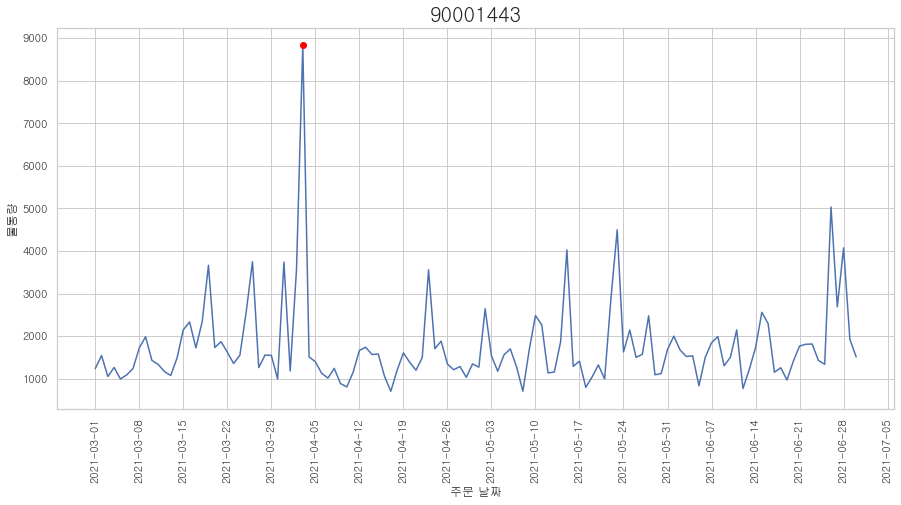

In [ ]:
tmp_df = top_10_df[top_10_df['고객사코드'] == 90001443]
tmp_df['주문 날짜'] = pd.to_datetime(tmp_df['주문 날짜'], format="%Y%m%d")


plt.figure(figsize=(15, 7))
ax = plt.subplot(1,1,1)
sns.lineplot(data = tmp_df, x='주문 날짜', y='품목수량')

ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 0))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
ax.xaxis.set_minor_locator(md.DayLocator(interval = 1))
plt.plot(datetime.strptime('2021-04-03', '%Y-%m-%d'), 8831, 'bo', color='red' )
plt.title(f'{90001443}', fontdict={'fontsize': 20})
plt.ylabel('물동량')
plt.show()

In [ ]:
# '기타' 항목의 경우 회귀 분석에서 상관성이 없다고 판별이 됐으나 일부 '기타' 이벤트에 한해 물동량에 끼치는 영향이 지대함을 확인
# 위 그래프와 같이 기타 항목에서도 물동량이 폭주하는 경우가 있어 날짜 - 물동량 그래프를 확인해 영향이 크다 판단한 데이터는 다른 이벤트 항목으로 이동시킴

tmp = top_10_df_event[top_10_df_event['기타'] == 1]
index = (~ tmp['주문 날짜'].isin(["2021-04-20", "2021-04-03", "2021-06-14", "2021-03-08"])).index.tolist()

top_10_2 = top_10_df_event.copy()

top_10_2.loc[index, '기타'] = 0
con1 = ((top_10_2['고객사코드'] == 90001441) & (top_10_2['주문 날짜'] == '2021-04-20')) # 라이온코리아 기타 이벤트
con2 = ((top_10_2['고객사코드'] == 90001443) & (top_10_2['주문 날짜'] == '2021-04-03')) # 애경 기타 상품이벤트
con3 = ((top_10_2['고객사코드'] == 90001443) & (top_10_2['주문 날짜'] == '2021-06-14')) # 애경 첫날 이벤트
con4 = ((top_10_2['고객사코드'] == 90001521) & (top_10_2['주문 날짜'] == '2021-03-08')) # 대상 첫날 이벤트

top_10_2.loc[con1 | con2 | con3 | con4, '기타'] = 1

In [ ]:
# 간과하기 어려운 이벤트 데이터들을 따로 모아서 추가적으로 회귀검증을 실시함.
my_model = smf.ols(formula = "품목수량 ~ C(브랜드데이) + C(브랜드위크) + C(쇼핑라이브) + C(타임특가) + C(기타)", data=top_10_2)
my_model = my_model.fit()
my_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   품목수량   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     211.3
Date:                Fri, 29 Oct 2021   Prob (F-statistic):          1.23e-156
Time:                        13:52:40   Log-Likelihood:                -9393.4
No. Observations:                1072   AIC:                         1.880e+04
Df Residuals:                    1066   BIC:                         1.883e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1415.5459     50.123     28.242      0.000    1317.195    1513.896
C(브랜드데이)[T.1]  8676.2338    531.663     16.319      0.000    7633.008    9719.459
C(브랜드위크)[T.1]  2069.0846    214.594      9.642      0.000    1648.010    2490.159
C(쇼핑라이브)[T.1]  3894.5687    235.076     16.567      0.000    3433.305    4355.832
C(타임특가)[T.1]   1273.5756    350.228      3.636      0.000     586.361    1960.790
C(기타)[T.1]     2293.4541    776.863      2.952      0.003     769.100    3817.808
==============================================================================
Omnibus:                      885.008   Durbin-Watson:                   1.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45632.703
Skew:                           3.401   Prob(JB):                         0.00
Kurtosis:                      34.231   Cond. No.                         16.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 앞서 실시한 회귀분석에서는 기타 항목의 유의확률(p-value)가 0.178로 높게 나왔으나 영향이 크다고 판단한 기타 항목만 남겨둔 채
## 다시 회귀분석을 실시하면 유의확률이 0.003으로 유의수준보다 작아 추출한 기타 이벤트의 경우 물동량과 유의미한 관계가 있음을 확인할 수 있음

In [ ]:
# 직전에 유효성을 파악한 4개의 데이터들을 적절한 column에 배치
condition = (top_10_2['기타'] == 1, '브랜드데이')
top_10_2.loc[condition] = top_10_2.loc[condition].replace(0, 1)
top_10_2.drop(['기타'], axis = 1, inplace=True)


In [ ]:
# Column명 변경
top_10_2 = top_10_2.rename({"브랜드데이" : "데이", "브랜드위크" : "위크"}, axis='columns')


In [ ]:
top_10_df = pd.merge(top_10_df, top_10_2, how='left', on=['고객사코드', '주문 날짜', '품목수량'])
top_10_df.head()

,고객사코드,주문 날짜,품목수량,데이,위크,쇼핑라이브,타임특가
0,90001302,2021-03-01,2772,0,0,0,0
1,90001302,2021-03-02,4334,0,0,0,0
2,90001302,2021-03-03,2326,0,0,0,0
3,90001302,2021-03-04,2189,0,0,0,0
4,90001302,2021-03-05,1903,0,0,0,0


# 이벤트 영향력 파생변수 생성

## 이벤트 직후는 물동량이 평시와 같아지거나 감소하는 경향을 보임
## 이벤트 다음 날의 물동량을 더 정확히 예측하기 위해 파생변수를 생성

$T일 이벤트 영향력$ = $\frac{1}{T-1일 이벤트 개수 + 1}$

## Ex) 뉴트리원(90001542) - 4/25 ~ 4/30
## 첫 날인 4/25의 경우 위크와 라이브 이벤트로 인해 5912의 물동량을 보이지만 다음날부터 감소하기 시작하며
## 예외적으로 4/30 쇼핑라이브와 브랜드 위크가 동시에 진행돼 물동량이 폭주함을 알 수 있다

In [ ]:
tmp_df = top_10_df[(top_10_df['고객사코드'] == 90001542) & (top_10_df['주문 날짜'] >= datetime.strptime('2021-04-25', '%Y-%m-%d')) & (top_10_df['주문 날짜'] <= datetime.strptime('2021-04-30', '%Y-%m-%d'))]
tmp_df

,고객사코드,주문 날짜,품목수량,데이,위크,쇼핑라이브,타임특가
787,90001542,2021-04-25,5912,0,1,1,0
788,90001542,2021-04-26,2679,0,1,0,0
789,90001542,2021-04-27,2618,0,1,0,0
790,90001542,2021-04-28,1890,0,1,0,0
791,90001542,2021-04-29,2166,0,1,0,0
792,90001542,2021-04-30,6283,0,1,1,0


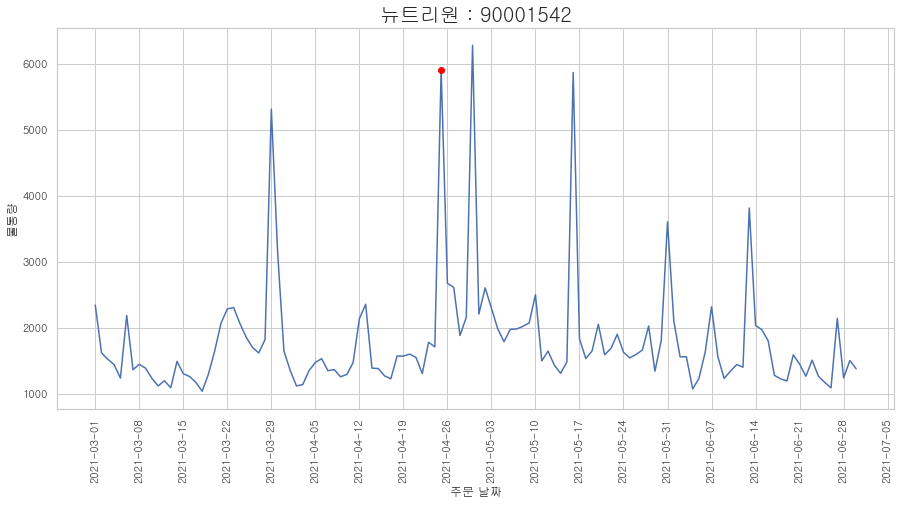

In [ ]:
tmp_df = top_10_df[top_10_df['고객사코드'] == 90001542]
tmp_df['주문 날짜'] = pd.to_datetime(tmp_df['주문 날짜'], format="%Y%m%d")


plt.figure(figsize=(15, 7))
ax = plt.subplot(1,1,1)
sns.lineplot(data = tmp_df, x='주문 날짜', y='품목수량')

ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 0))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
ax.xaxis.set_minor_locator(md.DayLocator(interval = 1))

plt.plot(datetime.strptime('2021-04-25', '%Y-%m-%d'), 5912, 'bo', color='red' )

plt.title(f'뉴트리원 : {90001542}', fontdict={'fontsize': 20})
plt.ylabel('물동량')
plt.show()

In [ ]:
new_top_10_df = top_10_df.copy()
summation = top_10_df[['데이', '위크', '쇼핑라이브', '타임특가']].sum(axis=1)


new_top_10_df['이벤트 영향력'] = np.power((1 / (summation+1)), 2).shift(1)
new_top_10_df['이벤트 영향력'].fillna(1, inplace=True)
new_top_10_df['이벤트 영향력'] = new_top_10_df['이벤트 영향력'].astype(int)

new_top_10_df.head()

,고객사코드,주문 날짜,품목수량,데이,위크,쇼핑라이브,타임특가,이벤트 영향력
0,90001302,2021-03-01,2772,0,0,0,0,1
1,90001302,2021-03-02,4334,0,0,0,0,1
2,90001302,2021-03-03,2326,0,0,0,0,1
3,90001302,2021-03-04,2189,0,0,0,0,1
4,90001302,2021-03-05,1903,0,0,0,0,1


In [ ]:
top_10_df = new_top_10_df

## 요일 추가

In [ ]:
top_10_df['요일']=pd.to_datetime(top_10_df['주문 날짜']).dt.dayofweek
top_10_df.head()

,고객사코드,주문 날짜,품목수량,데이,위크,쇼핑라이브,타임특가,이벤트 영향력,요일
0,90001302,2021-03-01,2772,0,0,0,0,1,0
1,90001302,2021-03-02,4334,0,0,0,0,1,1
2,90001302,2021-03-03,2326,0,0,0,0,1,2
3,90001302,2021-03-04,2189,0,0,0,0,1,3
4,90001302,2021-03-05,1903,0,0,0,0,1,4


# 시계열 분석
- 정상성 테스트(ADF TEST)

In [ ]:
## 데이터 정상성 테스트 및 AR/MA 모형 진단
import statsmodels.tsa.stattools as sts

In [ ]:
# adf test

def adf_test(df):
    try:
        p_value = sts.adfuller(df["품목수량"])[1]
    except ValueError:
        result = '비정상'
        return None, None
        
    if p_value < 0.05:
        result = '정상성'
    else:
        result = '[비정상성]'
    
    return p_value, result

In [ ]:
# 정상성 만족
adf_test_result = []
stationary_days = []
top_10_df_list = [top_10_df[top_10_df['고객사코드'] == num]for num in top_10_num_list]

for num, custom in zip(top_10_num_list, top_10_df_list): 
    tmp_df = custom.groupby(['고객사코드', '주문 날짜'])['품목수량'].sum().reset_index()
    p_value, result = adf_test(tmp_df)
    if p_value == None:
        adf_test_result.append((f'{num} 고객사는 sample size가 너무 적어 계산 불가합니다.'))
    else:
        adf_test_result.append((f'{num} 고객사는 p_value가 :{round(p_value, 3)}이므로 {result}입니다.'))
        if result == '정상성':
            stationary_days.append(tmp_df)

    
print(len(top_10_num_list), '고객사')
for result in adf_test_result:
    print(result)

10 고객사
90001302 고객사는 p_value가 :0.0이므로 정상성입니다.
90001541 고객사는 p_value가 :0.0이므로 정상성입니다.
90001542 고객사는 p_value가 :0.0이므로 정상성입니다.
90001443 고객사는 p_value가 :0.0이므로 정상성입니다.
90001341 고객사는 p_value가 :0.0이므로 정상성입니다.
90001441 고객사는 p_value가 :0.0이므로 정상성입니다.
90001602 고객사는 p_value가 :0.0이므로 정상성입니다.
90001582 고객사는 p_value가 :0.0이므로 정상성입니다.
90001622 고객사는 p_value가 :0.0이므로 정상성입니다.
90001521 고객사는 p_value가 :0.0이므로 정상성입니다.


## ACF, PACF test
- 정상성을 통과한 모든 고객사들이 다음과 같은 ACF, PACF 형태를 가지고 있다.
- lag 1을 제외한 거의 모든 lag에서 자기상관계수가 신뢰구간 내에 파묻혀 있다. 사실상 noise와 구분하기 힘들 정도이다
- 또한 주기적으로 자기상관계수가 신뢰구간 상, 하한을 벗어나는 모습도 보이지 않으므로 주기성을 가진다고 하기도 어렵다


In [ ]:
import statsmodels.graphics.tsaplots as sgt 

In [ ]:
top_10_df_event_copy = top_10_df_event.copy()
top_10_df_event_copy = top_10_df_event_copy[['고객사코드', '주문 날짜', '품목수량']]
top_10_df_event_copy

,고객사코드,주문 날짜,품목수량
0,90001302,2021-03-01,2772
1,90001302,2021-03-02,4334
2,90001302,2021-03-03,2326
3,90001302,2021-03-04,2189
4,90001302,2021-03-05,1903
...,...,...,...
1067,90001622,2021-06-26,1077
1068,90001622,2021-06-27,1557
1069,90001622,2021-06-28,1421
1070,90001622,2021-06-29,2519


In [ ]:
top_10_df_event_copy_list = {}

for i in top_10_df_event_copy['고객사코드'].unique() :
    top_10_df_event_copy_list[i] = top_10_df_event_copy[top_10_df_event_copy['고객사코드'] == i][['주문 날짜', '품목수량']].groupby('주문 날짜')['품목수량'].sum()

# 생활공작소(90001341) - winsorize 전후의 ACF와 PACF를 시각화

In [ ]:
top_10_df_event_copy_list[90001341]

주문 날짜
2021-03-01    1492
2021-03-02    1283
2021-03-03    1219
2021-03-04    3492
2021-03-05    8815
              ... 
2021-06-26     871
2021-06-27    1338
2021-06-28    1314
2021-06-29    1906
2021-06-30    1443
Name: 품목수량, Length: 122, dtype: int64

# 생활공작소(90001341) - winsorize하기 전의 값
# 잔차가 시간에 따라 독립적이지 않은 모습을 확인할 수 있고, 분포가 right-skewed된 것을 kdeplot을 통해 확인할수 있다.

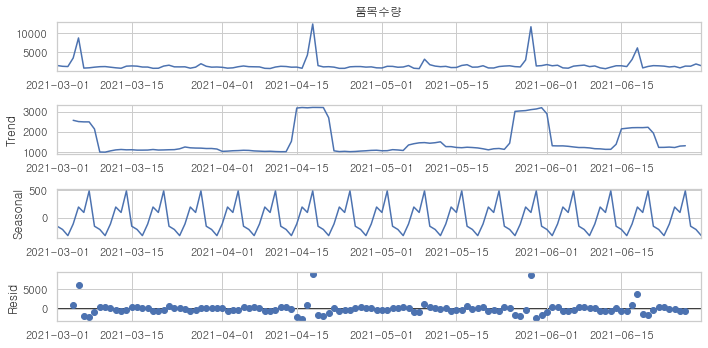

<AxesSubplot:xlabel='resid', ylabel='Count'>

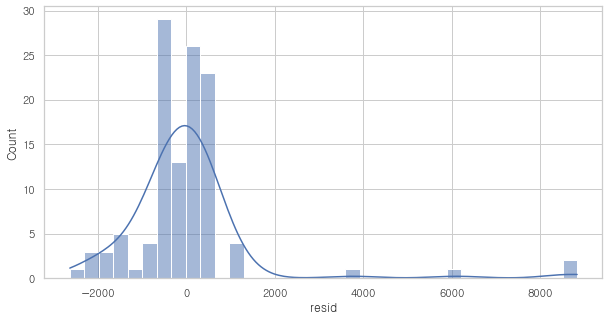

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = (10, 5)
result1 = seasonal_decompose(top_10_df_event_copy_list[90001341], model='additive', period = 7)
result1.plot()
plt.show()

residual = result1.resid
sns.histplot(residual, kde=True)

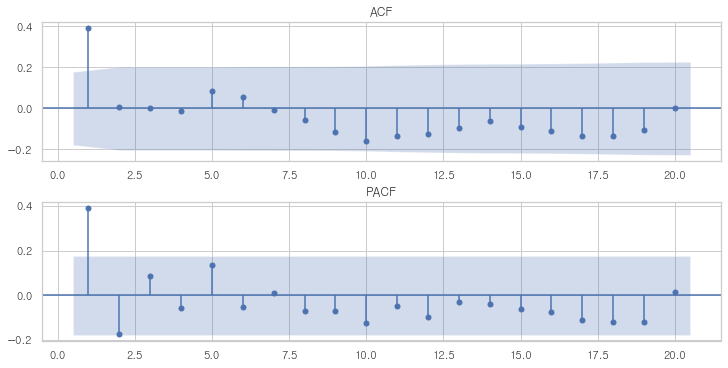

In [ ]:
fig = plt.figure(figsize=(10, 5), constrained_layout=True)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

tmp_df = top_10_df_list[0]  # 90001341 생활공작소

sgt.plot_acf(tmp_df['품목수량'], lags = 20, zero = False, ax=ax1)
ax1.set_title("ACF")


sgt.plot_pacf(tmp_df['품목수량'], lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF")

plt.show()

## winsorize 전의 ACF / PACF를 보면 Lag > 1 구간에서 노이즈의 신뢰구간 안에서 움직여 일별 관측치간 상관관계가 없음을 알 수 있다.
## 즉 물동량이 다음날, 또는 그 이후에 주는 영향이 적거나 없다는 것을 알 수 있다.

# 생활공작소(90001341) - 상위 10% 값에 대해 winsorize를 진행 후 ACF / PACF 시각화

In [ ]:
from scipy.stats.mstats import winsorize
winsorized_top_10_df = {}

# 상위 10% 값을 winsorize
for i in top_10_df_event_copy['고객사코드'].unique():
    winsorized_top_10_df[i] = pd.Series(winsorize(top_10_df_event_copy_list[i].values, limits=[0, 0.1]))

## winsoring 후 잔차의 평균은 0에 가깝게, 분산은 정규 분포꼴을 띠는 모습

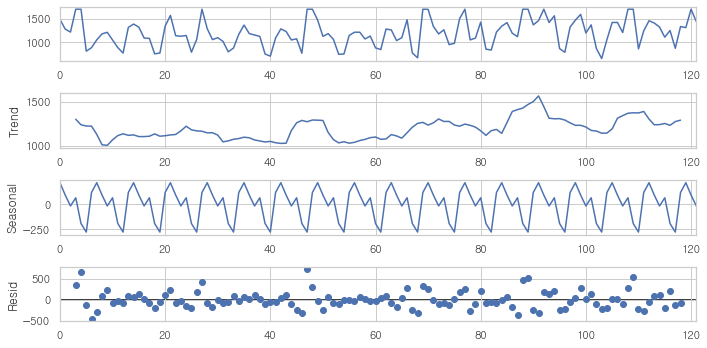

<AxesSubplot:xlabel='resid', ylabel='Count'>

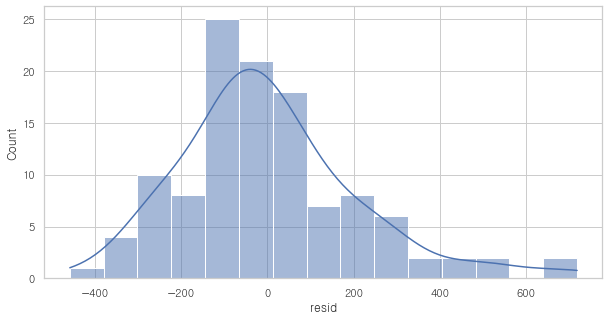

In [ ]:
plt.rcParams['figure.figsize'] = (10, 5)
result1 = seasonal_decompose(winsorized_top_10_df[90001341], model='additive', period = 7)
result1.plot()
plt.show()

residual = result1.resid
sns.histplot(residual, kde=True)

## winsorize 이후 생활공작소(90001341)의 ACF / PACF
## 이전과 달리 주기성이 개선돼 평시데이터의 주기성을 예측할 수 있을거라 기대

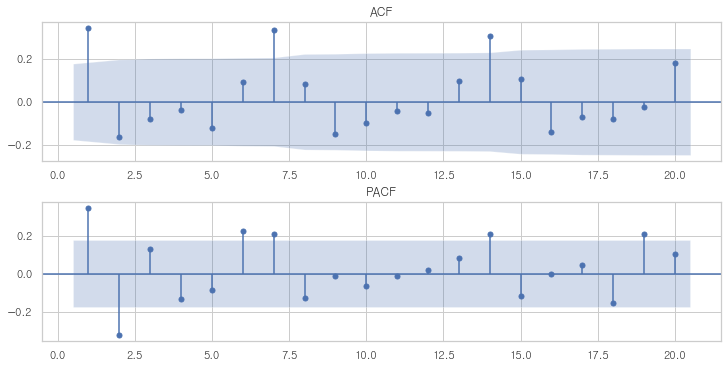

In [ ]:
fig = plt.figure(figsize=(10, 5), constrained_layout=True)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

tmp_df = winsorized_top_10_df[90001341]

sgt.plot_acf(tmp_df, lags = 20, zero = False, ax=ax1)
ax1.set_title("ACF")

sgt.plot_pacf(tmp_df, lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF")

plt.show()

## SARIMAX 모델 학습
- ARIMA에 계절성을 고려한 기존의 SARIMA에 추가하여, 외인성(exogenous) 또한 고려함.
- 현재 이벤트 등의 외부 요인으로 물동량의 영향이 크다고 생각하여 모델을 선택하게 됨.
- SARIMA 모델에서는 diff 함수에 lag인자를 추가해 계절적 차분을 수행.
- 이 때, lag 값에는 원 데이터의 주기(m)값이 들어감.

### 결과
- 유의수준을 0.05로 설정
- 주문량 상위 10개 기업 중에서 p-value가 유의수준보다 큰 경우가 8개나 됨.
- 또한 Q-Q plot을 통해 기대했던 정규성에 미치지 못하였으며 잔차의 분산 또한 일정하지 않았음.
- 결과적으로 이 Data에는 SARIMA 모델을 적용하여 유의미한 결과를 예측하기는 힘들다고 판단.


90001302
                                     SARIMAX Results                                      
Dep. Variable:                               품목수량   No. Observations:                  122
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -944.372
Date:                            Fri, 29 Oct 2021   AIC                           1898.745
Time:                                    13:52:48   BIC                           1911.567
Sample:                                03-01-2021   HQIC                          1903.928
                                     - 06-30-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0100      0.219      0.046      0.964      -0.419       0.439
ma.L1          0.4908     

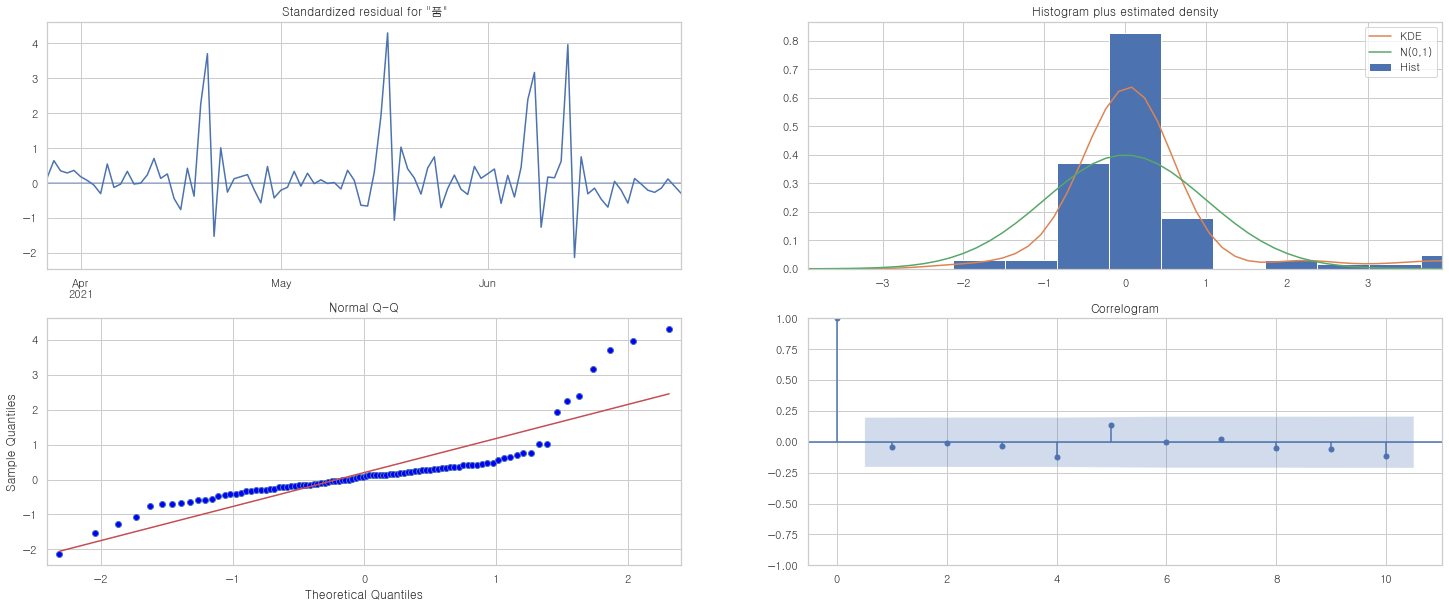

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as tsa
from matplotlib import pyplot
import itertools

# p, d, q : 0 ~ 1 범위값 설정
p = d = q = range(0, 2)

# p, d, q 값의 모두 다른 조합 생성
pdq = list(itertools.product(p, d, q))

# 계절성 고려 p, d, q 값의 모두 다른 조합 생성
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


top_df_for_sarima = top_10_df_event_copy.iloc[:, :3]

# 대표적으로 1개의 그래프만 보여줌
try :
    for i in top_df_for_sarima['고객사코드'].unique():
        sarima = top_df_for_sarima
        sarima = sarima[sarima['고객사코드'] == i].drop('고객사코드', axis=1)
        sarima['주문 날짜'] = pd.to_datetime(sarima['주문 날짜'])
        sarima = sarima.set_index('주문 날짜', drop=True, append=False)
        param_list = []
        param_seasonal_list = []
        results_AIC_list = []

        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    mod = tsa.statespace.SARIMAX(sarima,order=param,
                                                    seasonal_order=param_seasonal,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                    results = mod.fit()
                    param_list.append(param)
                    param_seasonal_list.append(param_seasonal)
                    results_AIC_list.append(results.aic)
                except:
                    continue

        ARIMA_list = pd.DataFrame({'Parameter':param_list,'Seasonal':param_seasonal_list,'AIC':results_AIC_list})

        a = ARIMA_list.sort_values(by='AIC')
        b = ARIMA_list.sort_values(by='AIC')
        a = a.set_index('Parameter', drop=True, append=False)
        b = b.set_index('Seasonal', drop=True, append=False)

        mod = tsa.statespace.SARIMAX(sarima,order=a.index[0],seasonal_order=b.index[0],
                                    enforce_stationarity=False, enforce_invertibility=False)
        results = mod.fit()
        print(i)
        print(results.summary())

        results.plot_diagnostics(figsize=(25, 10))
        plt.show()
        break

except:
    pass

# 변수들 간의 상관계수
## 대다수의 이벤트가 품목수량과 상관관계가 크고 이벤트 영향력 또한 음의 상관관계를 가지고 있는 것을 알 수 있다.

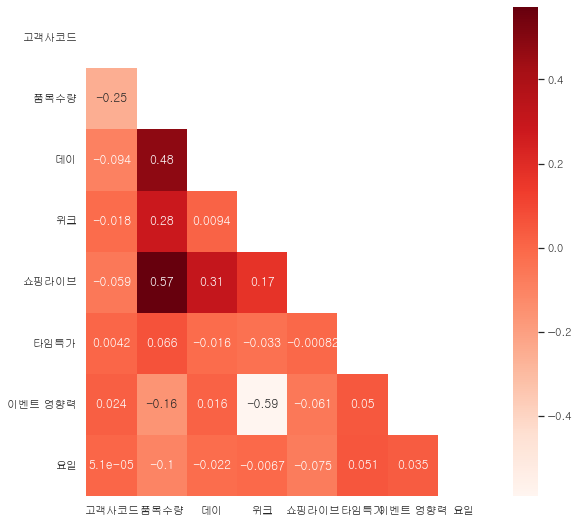

In [ ]:
c = top_10_df.corr()
mask = np.zeros_like(c, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(9, 9))
sns.heatmap(c, cmap='Reds', mask=mask, annot=True)
plt.xticks(rotation =0)
plt.yticks(rotation =0)
plt.show()

# 모델 학습 및 성능 평가

## XGBoost
- 각 고객사별로 성능을 하기 때문에 단순 MSE, RMSE로만 성능을 평가하는 것은 고객사마다 값의 편차가 있기 때문에 MAPE로 성능 지표를 설정

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# x, y데이터를 분리하기 쉽도록 만듦
def make_xy(df, num=False, encoding=False):
    col_len = len(df.columns)
    last_col = df.pop('품목수량')
    
    
    df.insert(col_len - 1, '품목수량', last_col)
    df = df.drop('주문 날짜', axis = 1)
    
    if encoding == False:

        X = df[df['고객사코드'] == num].iloc[:, 1:-1].reset_index()
        y = df[df['고객사코드'] == num].iloc[:, -1]
    
    else:
        X = df.iloc[:, :-1].reset_index()
        y = df.iloc[:, -1]
        
    
    return X, y

In [ ]:
def MAPE(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [ ]:
input_data = top_10_df.copy()
input_data.head()

,고객사코드,주문 날짜,품목수량,데이,위크,쇼핑라이브,타임특가,이벤트 영향력,요일
0,90001302,2021-03-01,2772,0,0,0,0,1,0
1,90001302,2021-03-02,4334,0,0,0,0,1,1
2,90001302,2021-03-03,2326,0,0,0,0,1,2
3,90001302,2021-03-04,2189,0,0,0,0,1,3
4,90001302,2021-03-05,1903,0,0,0,0,1,4


## Winsorize 전후 ACF / PACF 등 시계열 분석을 통해 시계열 특성이 무의미하다 판단했기 때문에 전체 데이터를 split할 때 시계열 특성은 고려하지 않고 무작위로 섞음

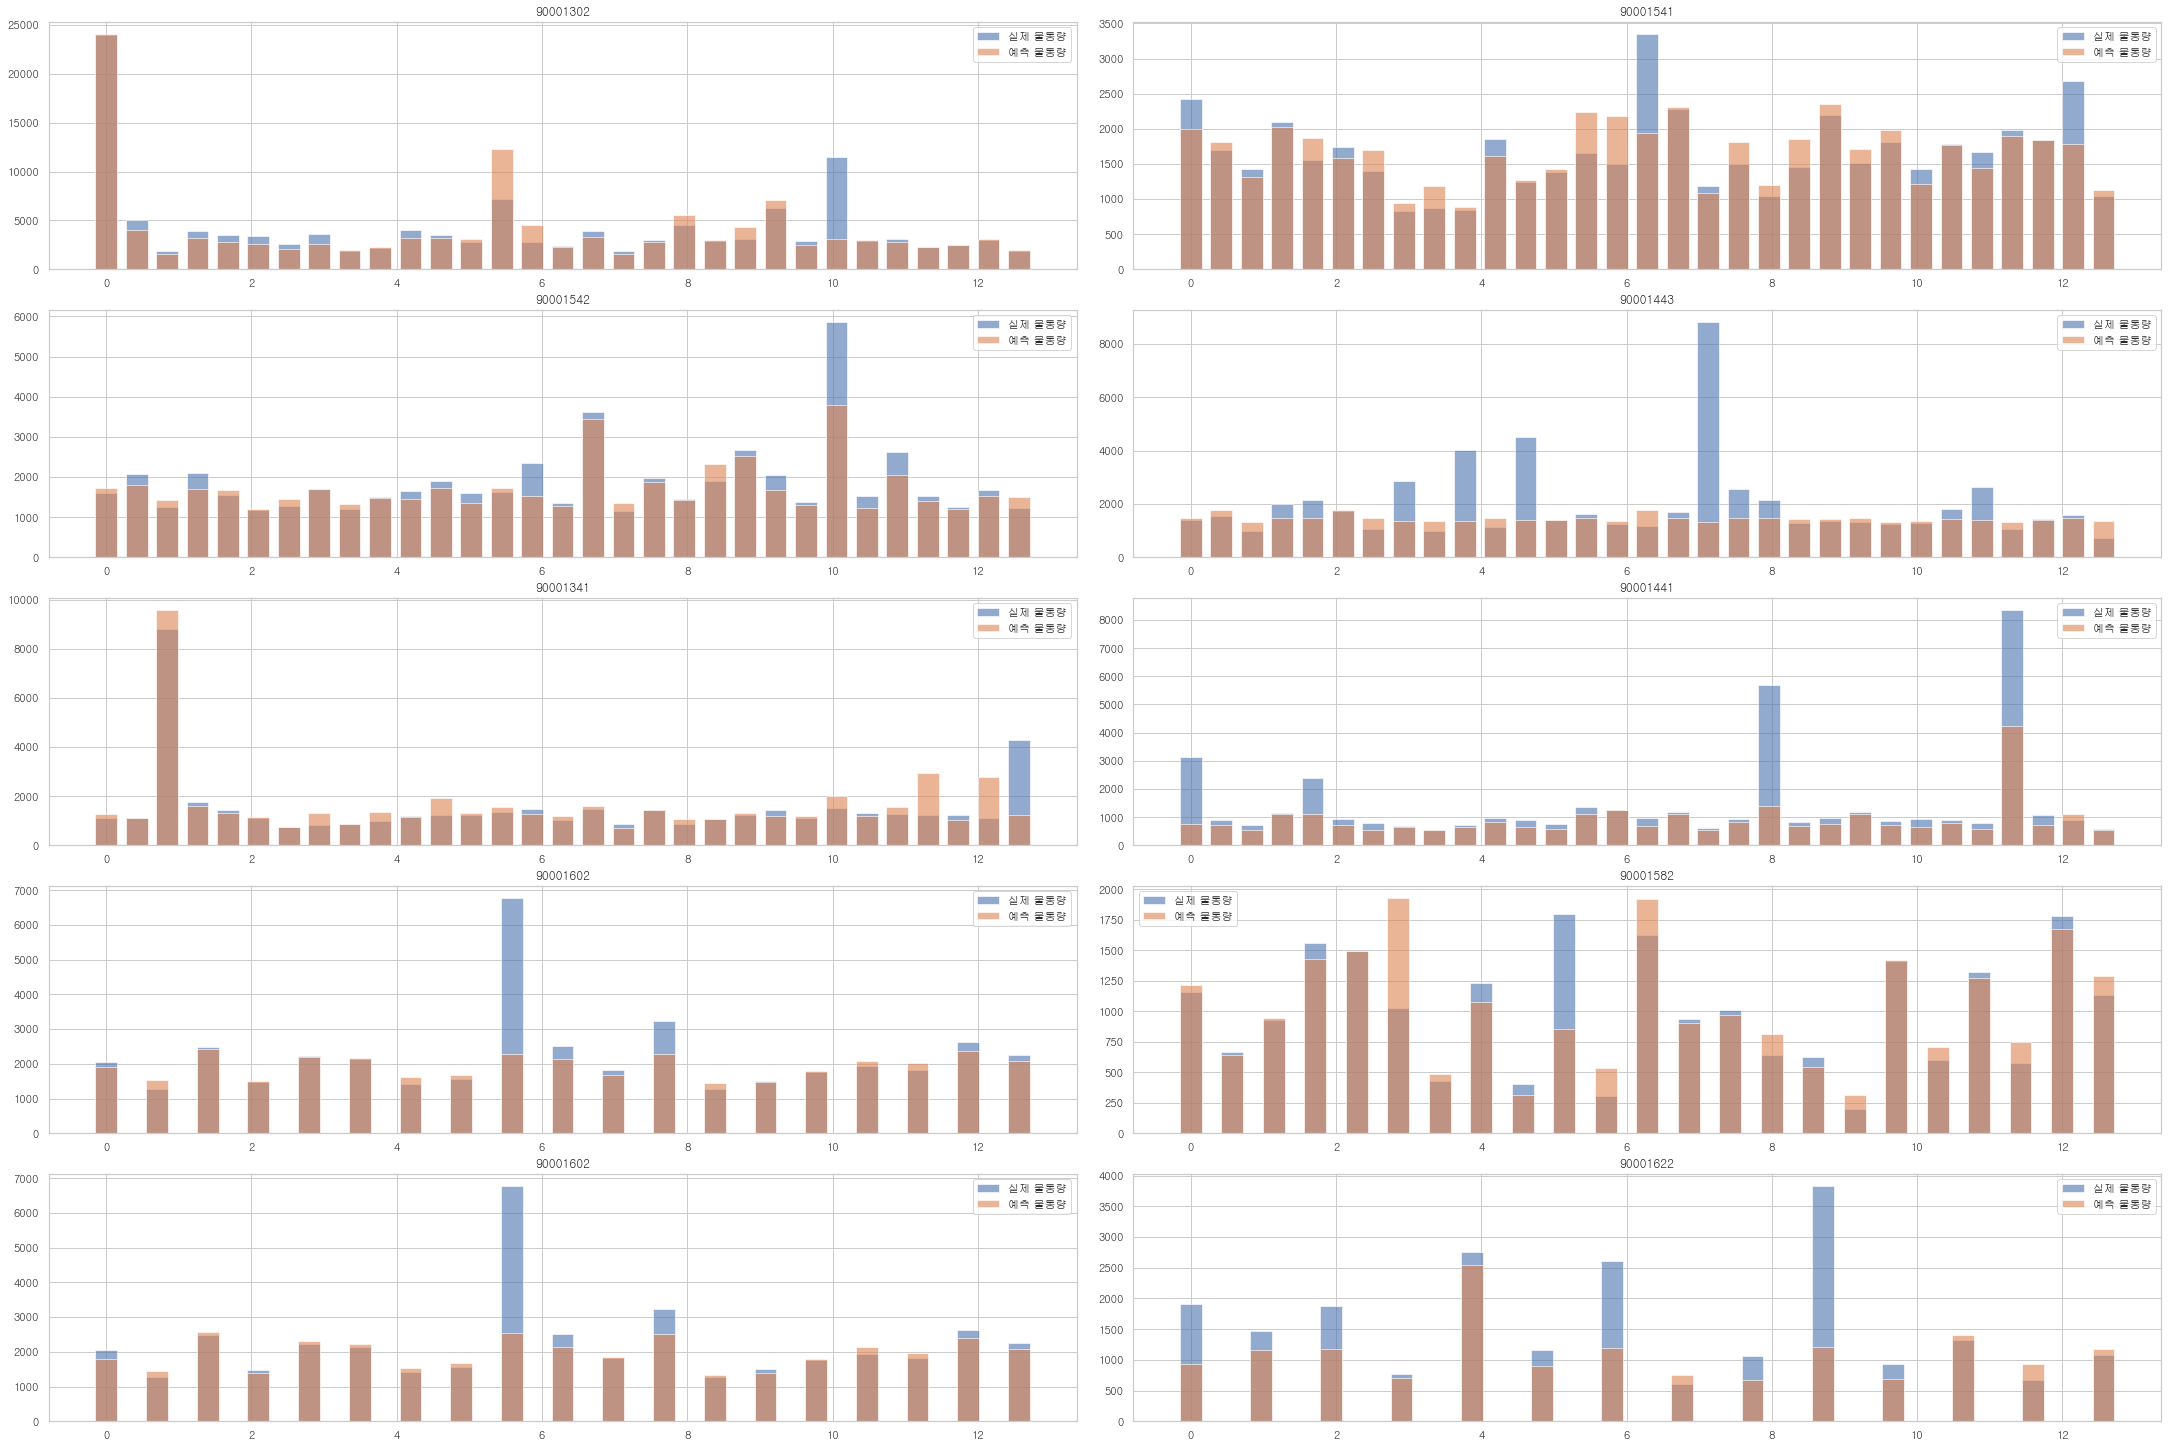

In [ ]:
# xgboost 실행

best_params = []
train_score = []
test_score = []
model_list = []
num_list = [90001302, 90001541, 90001542, 90001443, 90001341, 90001441, 90001602, 90001582, 90001602, 90001622]
# 미리 GridSearchCV를 통해 학습시킨 최적의 파라미터이다.
fit_params = [
{'alpha': 9, 'colsample_bylevel': 0.1, 'colsample_bytree': 0.9, 'gamma': 2, 'lambda': 1, 'n_estimators': 100},
{'alpha': 8, 'colsample_bytree': 0.7, 'eta': 0.11, 'gamma': 1, 'lambda': 3, 'learning_rate': 0.006, 'n_estimators': 1000},
{'alpha': 2, 'colsample_bytree': 0.7, 'eta': 0.11, 'gamma': 1.5, 'lambda': 4, 'learning_rate': 0.021, 'n_estimators': 200},
{'alpha': 2, 'colsample_bytree': 0.5, 'eta': 0.11, 'gamma': 1, 'lambda': 9, 'learning_rate': 0.02600000000000002, 'n_estimators': 100},
{'alpha': 8, 'colsample_bytree': 0.7, 'eta': 0.11, 'gamma': 2, 'lambda': 9, 'learning_rate': 0.041, 'n_estimators': 800},
{'alpha': 8, 'colsample_bytree': 1.0, 'eta': 0.11, 'gamma': 2, 'lambda': 2, 'learning_rate': 0.006, 'n_estimators': 250},
{'alpha': 9, 'colsample_bytree': 0.7, 'eta': 0.11, 'gamma': 1, 'lambda': 6, 'learning_rate': 0.056, 'n_estimators': 100},
{'alpha': 6, 'colsample_bytree': 0.7, 'eta': 0.11, 'gamma': 2, 'lambda': 9, 'learning_rate': 0.091, 'n_estimators': 400},
{'alpha': 5, 'colsample_bytree': 0.7, 'eta': 0.11, 'gamma': 2.5, 'lambda': 5},
{'alpha': 0, 'colsample_bytree': 0.5, 'eta': 0.01, 'gamma': 1, 'lambda': 1, }
]

plt.subplots(figsize=(30, 20), constrained_layout=True)

for i, num in enumerate(num_list):
    ax = plt.subplot(5, 2, i+1)
    X, y = make_xy(input_data, num)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=112)
    xgb_reg = XGBRegressor(n_jobs = -1, **fit_params[i])
    xgb_reg.fit(X_train, y_train)
    
    # 예측값
    model_list.append(xgb_reg)
    
    y_pred = xgb_reg.predict(X_test)
    X = np.linspace(0, 4 * np.pi, len(y_test))
    ax.bar(X, y_test, alpha=0.6, width=0.3)
    ax.bar(X, y_pred, alpha=0.6, width=0.3)
    plt.title(num)
    plt.legend(['실제 물동량', '예측 물동량'] )
    test_score.append((num, mean_squared_error(y_test, y_pred), MAPE(y_test, y_pred)))
    
plt.show()

In [ ]:
for info in test_score:
    custom, mse, mape = info[0], info[1], info[2]
    print(f'{custom}의 RMSE : {round(mse ** 0.5, 2)}, MAPE : {round(mape, 2)}')

90001302의 RMSE : 1879.71, MAPE : 18.38
90001541의 RMSE : 390.27, MAPE : 14.89
90001542의 RMSE : 456.6, MAPE : 11.96
90001443의 RMSE : 1617.46, MAPE : 28.74
90001341의 RMSE : 743.42, MAPE : 25.33
90001441의 RMSE : 1189.73, MAPE : 22.84
90001602의 RMSE : 1070.8, MAPE : 12.03
90001582의 RMSE : 297.25, MAPE : 20.54
90001602의 RMSE : 1002.06, MAPE : 10.98
90001622의 RMSE : 882.17, MAPE : 29.14


In [ ]:
mape_sum = 0
for info in test_score:
    tmp_mape = info[2]
    mape_sum += tmp_mape
print(f'평균 MAPE는 {round(mape_sum / 10, 2)} 입니다.')

평균 MAPE는 19.48 입니다.


## Ex) 네슬레코리아(90001541) Xgboost 변수 중요도

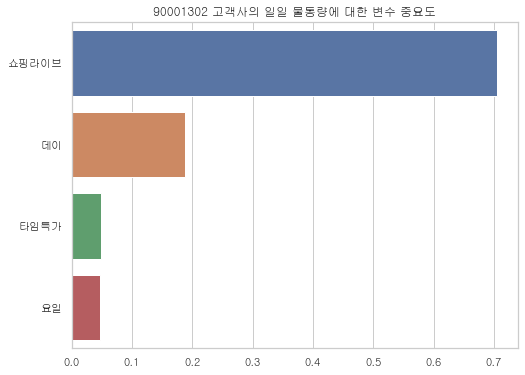

In [ ]:
ft_importance_values = model_list[1].feature_importances_

ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top4 = ft_series.sort_values(ascending=False)[:4]

# 시각화
plt.figure(figsize=(8,6))
plt.title('90001302 고객사의 일일 물동량에 대한 변수 중요도')
sns.barplot(x=ft_top4, y=ft_top4.index)
plt.show()